# Commodity Trading with Regret

### Background: Evans' Example 4.6.2
In **Chapter 4, Example 2 (Commodity Trading)**, Evans introduces a model for optimal trading. The model relies on the assumption that "the price of the wheat is known for the entire trading period". This is extremely unrealistic. Nonetheless, this model provides a baseline, "how well could have I performed had I known the future?". It thus allows us to measure the regret of a given strategy.

---

### The Goal: Back-Testing with a Theoretical Ceiling
We propose a **Regret Minimization** challenge.
Suppose we trade a highly cyclical sector (e.g., **XLE**, the Energy Sector). Theoretically, a Machine Learning model should be able to learn the "Buy Low, Sell High" trends. By using the Pontryagin Maximum Principle (PMP), we can compute the **absolute best possible performance** for any given price history and use this to train our model.

We measure our loss involving the regret factor:
$$\text{Regret} = (\text{Theoretical Best via PMP}) - (\text{Neural Network Performance})$$

---

### The Pipeline
We will implement the following 5-step workflow:

1.  **Extract Physics:** Download **XLE** (Energy ETF) data. Perform a cyclical curve fit to extract trend, frequency ($\omega$), and amplitude ($A$) statistics.
2.  **The Multiverse:** Generate "Alternate Universes" (synthetic sample paths) based on the statistics extracted in Step 1.
3.  **The Oracle (PMP):** Compute the "absolute best" trading strategy for each alternate universe using Evans' PMP solution (since we know the full history in the simulation).
4.  **The Student (ML):** Instantiate a Neural Network (e.g., LSTM) to learn the trading strategy. The model is trained to minimize the **regret** (imitate the Oracle).
5.  **The Final Exam:** Back-test the trained model on **Real XLE Data** to see if it captured the underlying physics of the market.

---

**Who will come out on top?**

Running on cpu
Fetching Market Data...
--- Market Physics Extracted ---
Annual Drift: 4.22%
Cycle Amplitude: 20.57%
Cycle Period: 8.92 Years
Noise Volatility: 23.06%


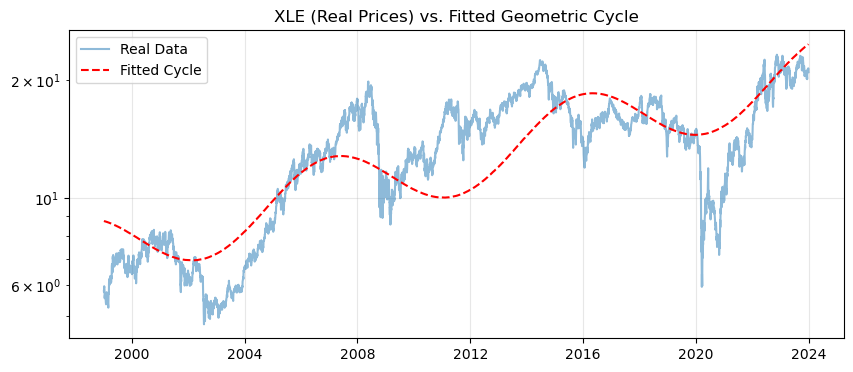

In [5]:
# Step 1: Imports and Data Extraction

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from pandas_datareader import data as pdr
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Configuration
START_DATE = '1999-01-01'
END_DATE = '2024-01-01'
ASSET_TICKER = 'XLE'  # Energy Sector ETF (Cyclical)
HOLDING_COST = 0.001  # Daily cost to hold a position (approx 2.5% annual)
MAX_RATE = 5.0        # Max shares to buy/sell per day
WINDOW_SIZE = 60      # Lookback window for the Neural Network
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Running on {DEVICE}")

# --- A. Data Ingestion ---
print("Fetching Market Data...")
asset_data = yf.download(ASSET_TICKER, start=START_DATE, end=END_DATE, progress=False)

# Robust Column Extraction
if isinstance(asset_data.columns, pd.MultiIndex):
    if 'Adj Close' in asset_data.columns.get_level_values(0):
        prices = asset_data['Adj Close'][ASSET_TICKER]
    elif 'Close' in asset_data.columns.get_level_values(0):
        prices = asset_data['Close'][ASSET_TICKER]
    else:
        raise KeyError("Price data not found.")
else:
    prices = asset_data['Adj Close'] if 'Adj Close' in asset_data.columns else asset_data['Close']

# Fetch CPI for Real Price Adjustment (Inflation)
try:
    cpi_data = pdr.DataReader('CPIAUCSL', 'fred', start=START_DATE, end=END_DATE)
    cpi_daily = cpi_data.resample('D').ffill().reindex(prices.index).ffill()
    cpi_factor = cpi_daily['CPIAUCSL'] / cpi_daily['CPIAUCSL'].iloc[0]
except:
    print("CPI fetch failed. Using nominal prices.")
    cpi_factor = pd.Series(1.0, index=prices.index)

real_prices = (prices / cpi_factor).dropna()
log_prices = np.log(real_prices.values)
t_values = np.arange(len(log_prices))

# --- B. The Physics Fit ---
def log_cyclical_model(t, drift, intercept, amp, omega, phase):
    return drift * t + intercept + amp * np.sin(omega * t + phase)

# Initial Guesses (7 year cycle approx)
guess_omega = 2 * np.pi / (252 * 7)
p0 = [(log_prices[-1]-log_prices[0])/len(log_prices), log_prices[0], np.std(log_prices), guess_omega, 0]

# Fit
params, _ = curve_fit(log_cyclical_model, t_values, log_prices, p0=p0)
drift, intercept, amp, omega, phase = params

# Extract Residuals (The Noise Profile)
fitted_curve = log_cyclical_model(t_values, *params)
residuals = log_prices - fitted_curve
noise_std = np.std(residuals)

print(f"--- Market Physics Extracted ---")
print(f"Annual Drift: {(np.exp(drift*252)-1)*100:.2f}%")
print(f"Cycle Amplitude: {amp*100:.2f}%")
print(f"Cycle Period: {(2*np.pi/omega)/252:.2f} Years")
print(f"Noise Volatility: {noise_std*100:.2f}%")

# Visualization
plt.figure(figsize=(10, 4))
plt.plot(real_prices.index, real_prices.values, label='Real Data', alpha=0.5)
plt.plot(real_prices.index, np.exp(fitted_curve), 'r--', label='Fitted Cycle')
plt.yscale('log')
plt.title(f"{ASSET_TICKER} (Real Prices) vs. Fitted Geometric Cycle")
plt.legend(); plt.grid(True, alpha=0.3); plt.show()